<a href="https://colab.research.google.com/github/jagatabhay/TSAI/blob/master/S9/QuizDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
from datetime import datetime
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-05-30 20:15:46.080255


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3),padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=16),
                                   nn.Conv2d(16,32,3, padding = 1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=32)
                                   )
                                   
        self.maxpool1 = nn.Sequential( nn.MaxPool2d(2,2) )
        
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=64),
                                   nn.Conv2d(64,64,3,padding = 1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=64),
                                   nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=128)
                                   )
                                   
        self.maxpool2 = nn.Sequential( nn.MaxPool2d(2,2) )
        
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3),padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=128),
                                   nn.Conv2d(128,128,3,padding = 1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=128),
                                   nn.Conv2d(128,10,3,padding = 1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features = 10)
                                   )
        
        self.gap  =  nn.Sequential( nn.AvgPool2d(kernel_size=8))
        self.fc = nn.Sequential( nn.Linear( 128,10) )
        
        
              


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.gap(x)
        #x = self.fc(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,640
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
           Conv2d-14          [-1, 128,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [5]:
%matplotlib inline
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose( [transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transform = transforms.Compose( [transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomCrop(32, padding=2),
                                       transforms.ColorJitter(brightness=0.1, contrast=0.1,saturation=0.1,hue=0.1),
                                       #transforms.RandomRotation( degrees = 7 ),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True,
                                        transform = train_transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = 30,
                                          shuffle=True, 
                                          num_workers = 4)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size = 30,
                                         shuffle=False,
                                         num_workers = 4)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 bird horse truck truck


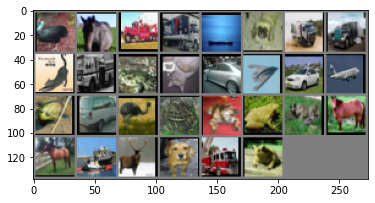

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9 , weight_decay = 0.001 )
scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
print("Device : ", device)

Device :  cuda


In [8]:
import time
start_time = time.time()
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device) , data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 300 == 299:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 300))
            running_loss = 0.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   300] loss: 1.810
[1,   600] loss: 1.590
[1,   900] loss: 1.471
[1,  1200] loss: 1.375
[1,  1500] loss: 1.312
[2,   300] loss: 1.214
[2,   600] loss: 1.150
[2,   900] loss: 1.099
[2,  1200] loss: 1.061
[2,  1500] loss: 1.031
[3,   300] loss: 0.966
[3,   600] loss: 0.932
[3,   900] loss: 0.913
[3,  1200] loss: 0.884
[3,  1500] loss: 0.862
[4,   300] loss: 0.821
[4,   600] loss: 0.820
[4,   900] loss: 0.792
[4,  1200] loss: 0.785
[4,  1500] loss: 0.770
[5,   300] loss: 0.727
[5,   600] loss: 0.729
[5,   900] loss: 0.715
[5,  1200] loss: 0.709
[5,  1500] loss: 0.696
[6,   300] loss: 0.687
[6,   600] loss: 0.665
[6,   900] loss: 0.652
[6,  1200] loss: 0.658
[6,  1500] loss: 0.651
[7,   300] loss: 0.619
[7,   600] loss: 0.634
[7,   900] loss: 0.623
[7,  1200] loss: 0.626
[7,  1500] loss: 0.601
[8,   300] loss: 0.576
[8,   600] loss: 0.593
[8,   900] loss: 0.577
[8,  1200] loss: 0.575
[8,  1500] loss: 0.587
[9,   300] loss: 0.543
[9,   600] loss: 0.542
[9,   900] loss: 0.546
[9,  1200] 

In [9]:
stop_time = time.time()
print("Time Taken To Train Time : ", stop_time - start_time)

Time Taken To Train Time :  533.4945225715637


In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device) , data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10000 test images: 83 %


In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device) , data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of plane : 81 %
Accuracy of   car : 92 %
Accuracy of  bird : 79 %
Accuracy of   cat : 69 %
Accuracy of  deer : 81 %
Accuracy of   dog : 78 %
Accuracy of  frog : 88 %
Accuracy of horse : 82 %
Accuracy of  ship : 91 %
Accuracy of truck : 93 %
